# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

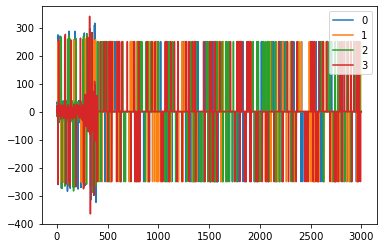

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

data = pd.read_csv('exampleco_data/machine_0.csv', index_col=0)

plt.plot(range(len(data)), data)
plt.legend(data.columns)
plt.show()

## Importing the libraries

In [2]:
#loading essential libraries
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
import datetime 
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

import warnings
warnings.filterwarnings('ignore')

### Changing the cell width for better display

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style."))

## Analyzing and Pre-processing of the data

### Data for Machine_0

In [4]:
data_0 = pd.read_csv('exampleco_data/machine_0.csv')
data_0.head()   

,Unnamed: 0,0,1,2,3
0,2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


#### For time series anaysis, I need DataTime as the index. So, I will first clean this data.

In [5]:
data_0.shape

(3000, 5)

#### The csv file has data for 3000 observations. After viewing, the observations, I got to know that there are 3 time entries for almost each date.

In [6]:
data_0.describe()

,0,1,2,3
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.816016,-1.091308,1.267945,0.165844
std,58.078319,55.965665,56.538700,56.910659
min,-323.954437,-258.780879,-287.153920,-365.362164
25%,-0.008684,-0.008851,-0.008274,-0.007883
50%,-0.000402,-0.000085,0.000669,0.000310
75%,0.007832,0.008373,0.009056,0.008685
max,315.738951,264.374782,281.684102,340.513819


In [7]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3000 non-null   object 
 1   0           3000 non-null   float64
 2   1           3000 non-null   float64
 3   2           3000 non-null   float64
 4   3           3000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 117.3+ KB


#### After looking at the info about the dataframe, I got to know that there are no null values. However, the data type of the date column is of the type 'object'. I need to first change it to 'datetime' data type. 

In [8]:
#first, renaming the unnamed column to DateTime as it contains information of date and time.
data_0.rename(columns={"Unnamed: 0":"DateTime"},inplace=True)

In [9]:
#changing the data type
data_0.DateTime = pd.to_datetime(data_0.DateTime)
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  3000 non-null   datetime64[ns]
 1   0         3000 non-null   float64       
 2   1         3000 non-null   float64       
 3   2         3000 non-null   float64       
 4   3         3000 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 117.3 KB


#### The data type for the column has been changed to 'datetime64'.  Since, the index of a time series is the date time itself, so I will make this column as the index. 

In [10]:
#setting datetime as the index
data_0.set_index('DateTime', inplace=True)
data_0.head()

,0,1,2,3
DateTime,,,,
2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


### Data for Machine_1

In [11]:
#cleaning data for machine 1
data_1 = pd.read_csv('exampleco_data/machine_1.csv')
data_1.rename(columns={"Unnamed: 0":"DateTime"}, inplace=True)
data_1.DateTime = pd.to_datetime(data_1.DateTime)
data_1.set_index("DateTime", inplace=True)

### Data for Machine_2

In [12]:
#cleaning data for machine 2
data_2 = pd.read_csv('exampleco_data/machine_2.csv')
data_2.rename(columns={"Unnamed: 0":"DateTime"}, inplace=True)
data_2.DateTime = pd.to_datetime(data_2.DateTime)
data_2.set_index("DateTime", inplace=True)

### Checking whether the data is stationary or not using Augmented Dickey-Fuller Test

In [13]:
#Null hypothesis: Data is stationary 
#Alternate hypothesis: Data is not stationary 

test_result = adfuller(data_0['0'])

def adfuller_test_for_stationary(signals):
    result = adfuller(signals)
    labels=['ADF Test Statistic', 'p-value', 'Number of lags used', 'Number of observations used']
    for value, label in zip(result, labels):
        print(label, ':', str(value))
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print('Data is non-stationary')

In [14]:
#results for Adfuller test for machine 0
adfuller_test_for_stationary(data_0['0'])
print("\n")
adfuller_test_for_stationary(data_0['1'])
print("\n")
adfuller_test_for_stationary(data_0['2'])
print("\n")
adfuller_test_for_stationary(data_0['3'])

ADF Test Statistic : -10.688768842011468
p-value : 3.773069895753304e-19
Number of lags used : 26
Number of observations used : 2973
Data is stationary


ADF Test Statistic : -54.48394063925739
p-value : 0.0
Number of lags used : 0
Number of observations used : 2999
Data is stationary


ADF Test Statistic : -54.68246868630116
p-value : 0.0
Number of lags used : 0
Number of observations used : 2999
Data is stationary


ADF Test Statistic : -25.360069322449636
p-value : 0.0
Number of lags used : 3
Number of observations used : 2996
Data is stationary


In [15]:
#results for Adfuller test for machine 1
adfuller_test_for_stationary(data_1['0'])
print("\n")
adfuller_test_for_stationary(data_1['1'])
print("\n")
adfuller_test_for_stationary(data_1['2'])
print("\n")
adfuller_test_for_stationary(data_1['3'])

ADF Test Statistic : -9.694438230629267
p-value : 1.1140574016889068e-16
Number of lags used : 29
Number of observations used : 2970
Data is stationary


ADF Test Statistic : -53.97260626521231
p-value : 0.0
Number of lags used : 0
Number of observations used : 2999
Data is stationary


ADF Test Statistic : -8.895874711163842
p-value : 1.2074064215880267e-14
Number of lags used : 29
Number of observations used : 2970
Data is stationary


ADF Test Statistic : -14.014046072970132
p-value : 3.669964962247916e-26
Number of lags used : 22
Number of observations used : 2977
Data is stationary


#### The data is stationary for machine_0 and 1, so I can proceed further by assuming that the same holds true for all the machines.

## Exploratory Data Analysis

#### Analyzing signals by plotting 300 signals in one graph

In [16]:
#plotting 300 points in one graph
def plot_graph(df):
    fig, ax = plt.subplots(10,1, figsize=(30,20))

    n = 300
    index = 0

    for i in range(0, len(df), n):
        ax[index].plot(range(i,i+n), df[i:i+n])
        index+=1

### Machine_0

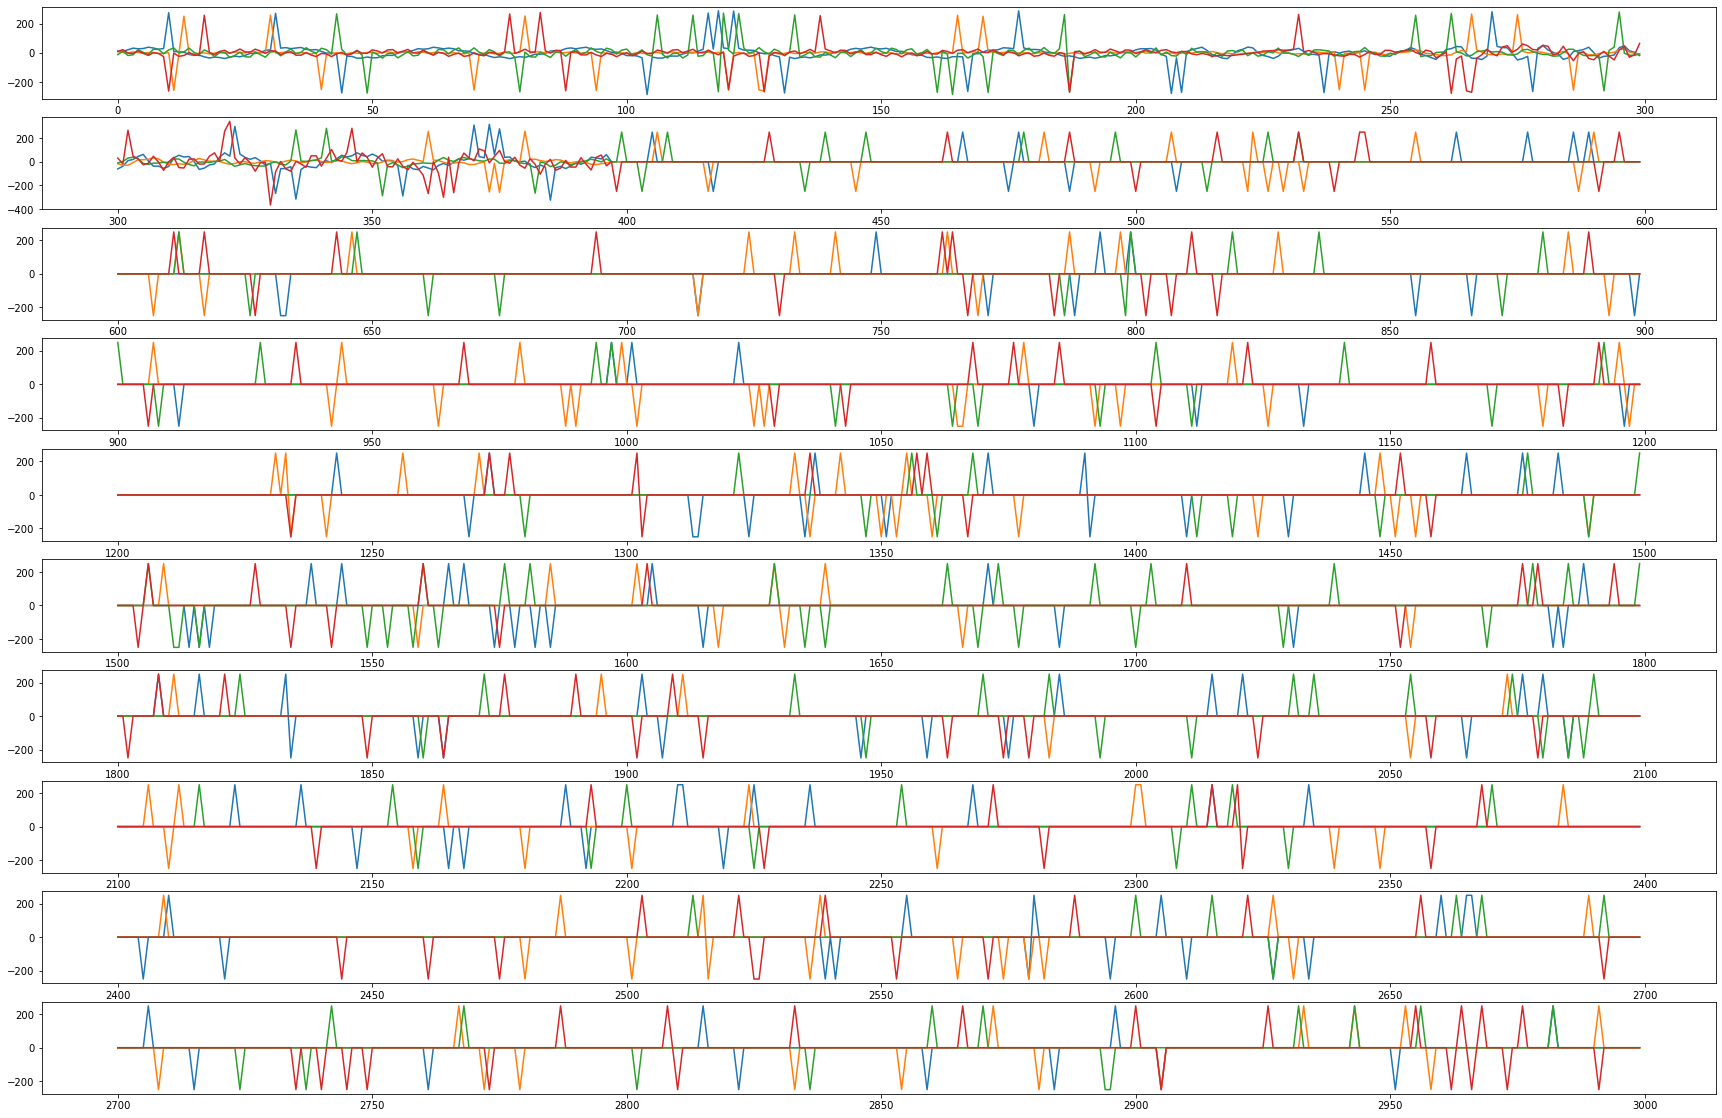

In [17]:
plot_graph(data_0)

### Machine_1

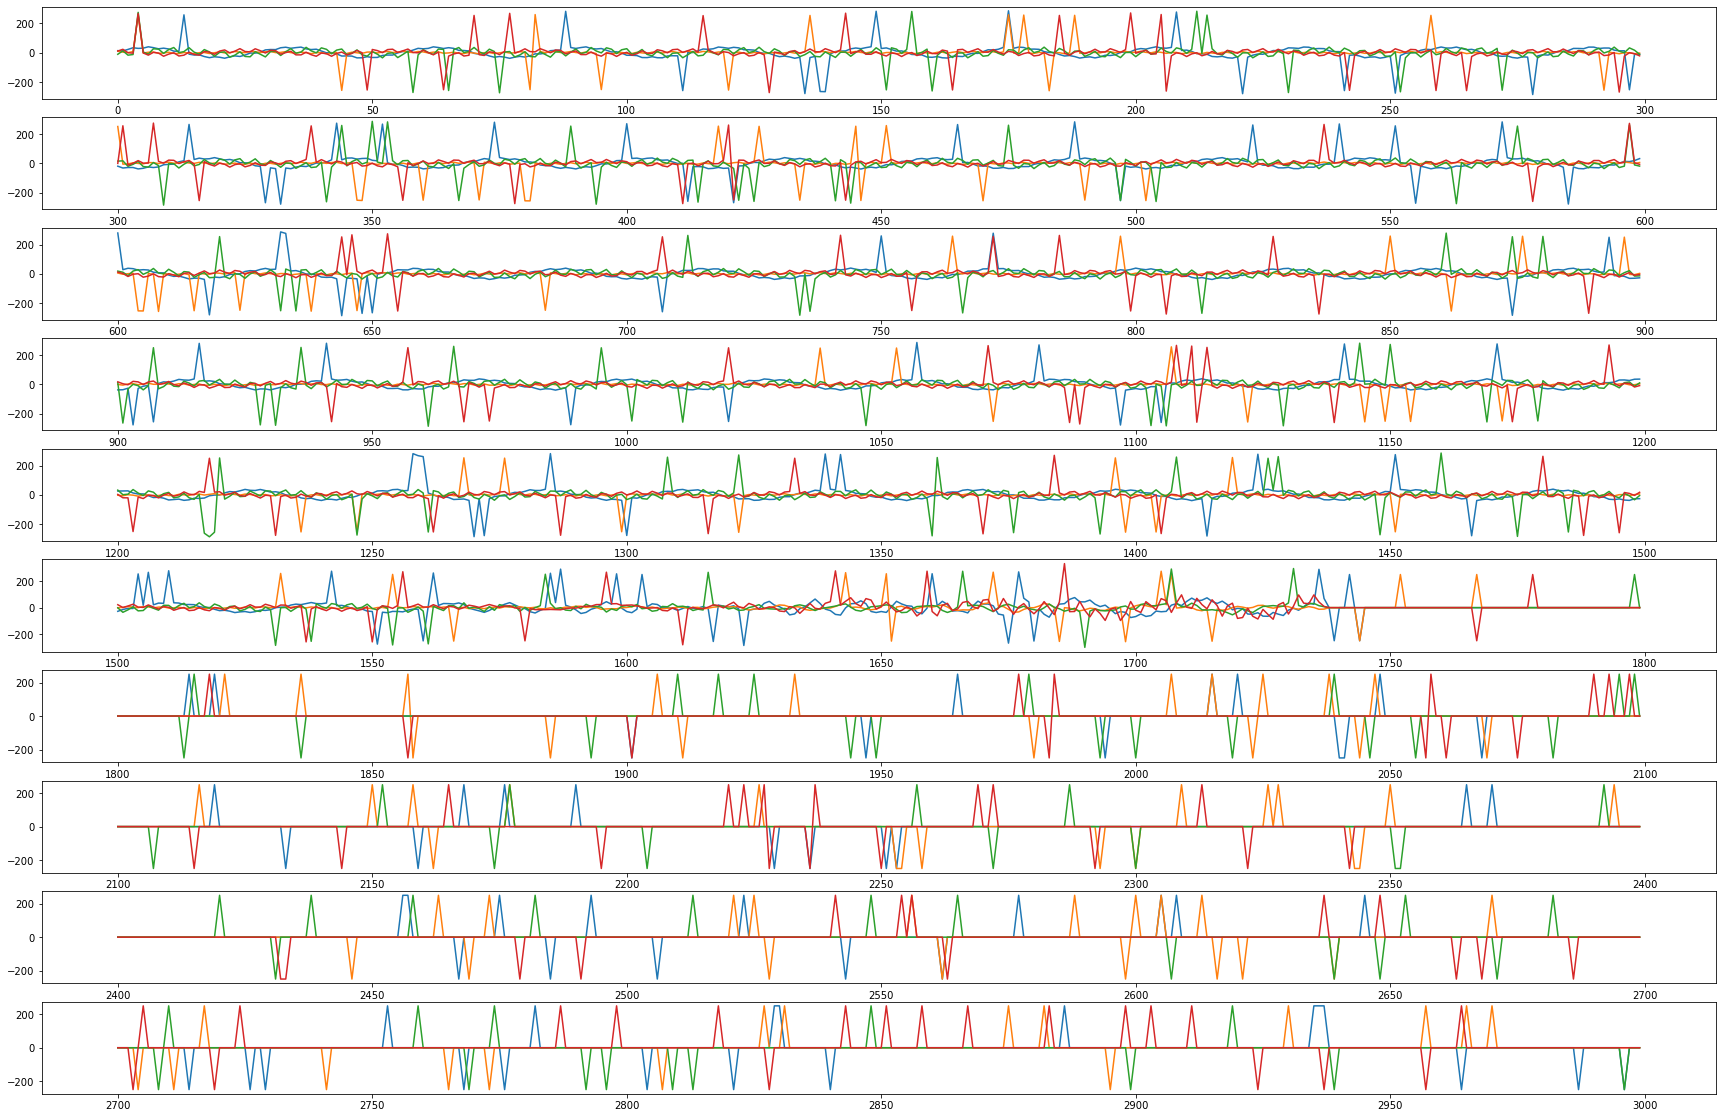

In [18]:
plot_graph(data_1)

### Machine_2

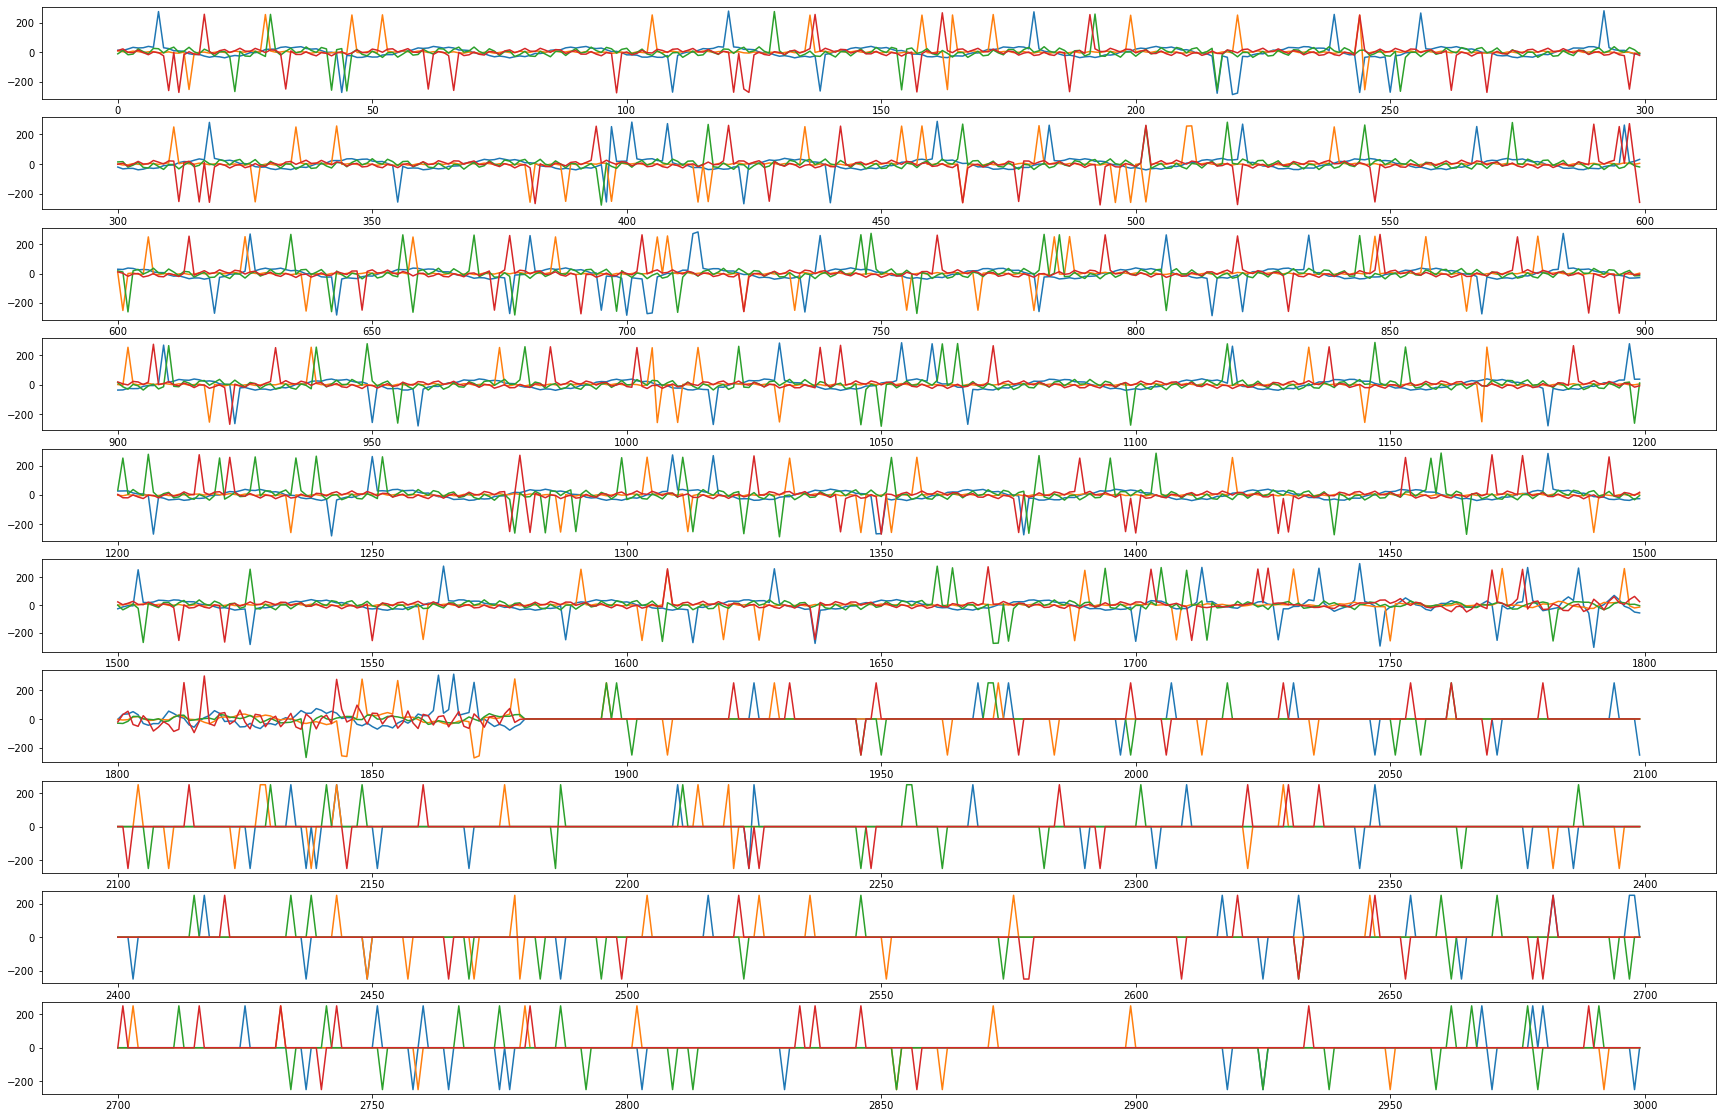

In [19]:
plot_graph(data_2)

#### It can be clearly observed from the graphs of these three machines that:
#### 1. the signals from faulty machines are quite different from the normal machines. 
#### 2. the failed machines shows signals very close to 0.
#### 3. there is noise due to communication errors.

#### I will first remove the noise and then move forward with the analysis. The noise are actually outliers which can be replaced by the mean or median values. I will replace all the outliers with mean. However, taking a single mean for the entire data is not a good idea as we have signals ranging between -350 and +350 approximately. So, instead I will take the rolling mean for a rolling window and replace the outlier with it. Any value which is more than or less than two standard deviations is considered an outlier as generally 95% of the data is contained within this range and rest 5% outside this range (provided the data follows a normal distribution). I am using this assumption to replace the outliers in my case too as it is generally works well.

## Dealing with outliers

In [20]:
rolling_window=60

#replacing outliers with mean
def replace_outliers(df, col_name, rolling_window=rolling_window, min_periods=1):
    df['rolling_mean'] = df.rolling(rolling_window, min_periods).mean()[col_name]
    
    threshold_min = df[col_name].mean() - 2*df[col_name].std()
    threshold_max = df[col_name].mean() + 2*df[col_name].std()

    
    df[col_name] = np.where((df[col_name] >= threshold_max) | (df[col_name] <= threshold_min), df['rolling_mean'], df[col_name])
    df.drop(['rolling_mean'],axis=1, inplace=True)

### Signals of Machine_0 after treating the outliers

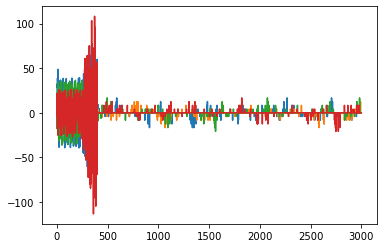

In [21]:
for i in range(0, 4):
    replace_outliers(data_0, str(i))

plt.plot(range(len(data_0)), data_0)
plt.show()

### Signals of Machine_1 after treating the outliers

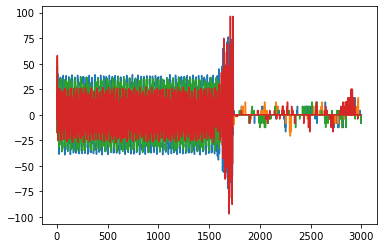

In [22]:
for i in range(0, 4):
    replace_outliers(data_1, str(i))

plt.plot(range(len(data_1)), data_1)
plt.show()

#### We can observe from the graphs that our range has changed a lot after outliers removal which indicates that most of the noise from the data has been removed.

## Model Building and Automation

#### Our problem has data of four different signals of each machine. Since, the problem is multivariate time series analysis/forecasting, so I am using the statistical model, Vector Auto Regression (VAR). VAR captures the relationship between multiple quantities as they change over time.

In [23]:
split_index=60

#creating prediction dataframe
def prediction_df(df, split_index=split_index):
    
    #creation of train and validation data
    train = df[:split_index]
    valid = df[:]
    
    #model fitting
    model = VAR(endog=train)
    model_fit = model.fit(maxlags=10, ic='aic')
    
    #To see the summary of the model, please uncomment the line
    #print(model_fit.summary())
    
    prediction = model_fit.forecast(model_fit.y, steps=len(valid))
    
    #dataframe for prediction
    pred_df = pd.DataFrame(index=df.index[:], columns=['0_pred','1_pred','2_pred','3_pred'])
    
    for j in range(0,4):
        for i in range(len(prediction)):
            pred_df.iloc[i][j] = prediction[i][j]
    
    return pred_df

pred_df_0 = prediction_df(data_0)

### Analyzing the just one signal of machine 0

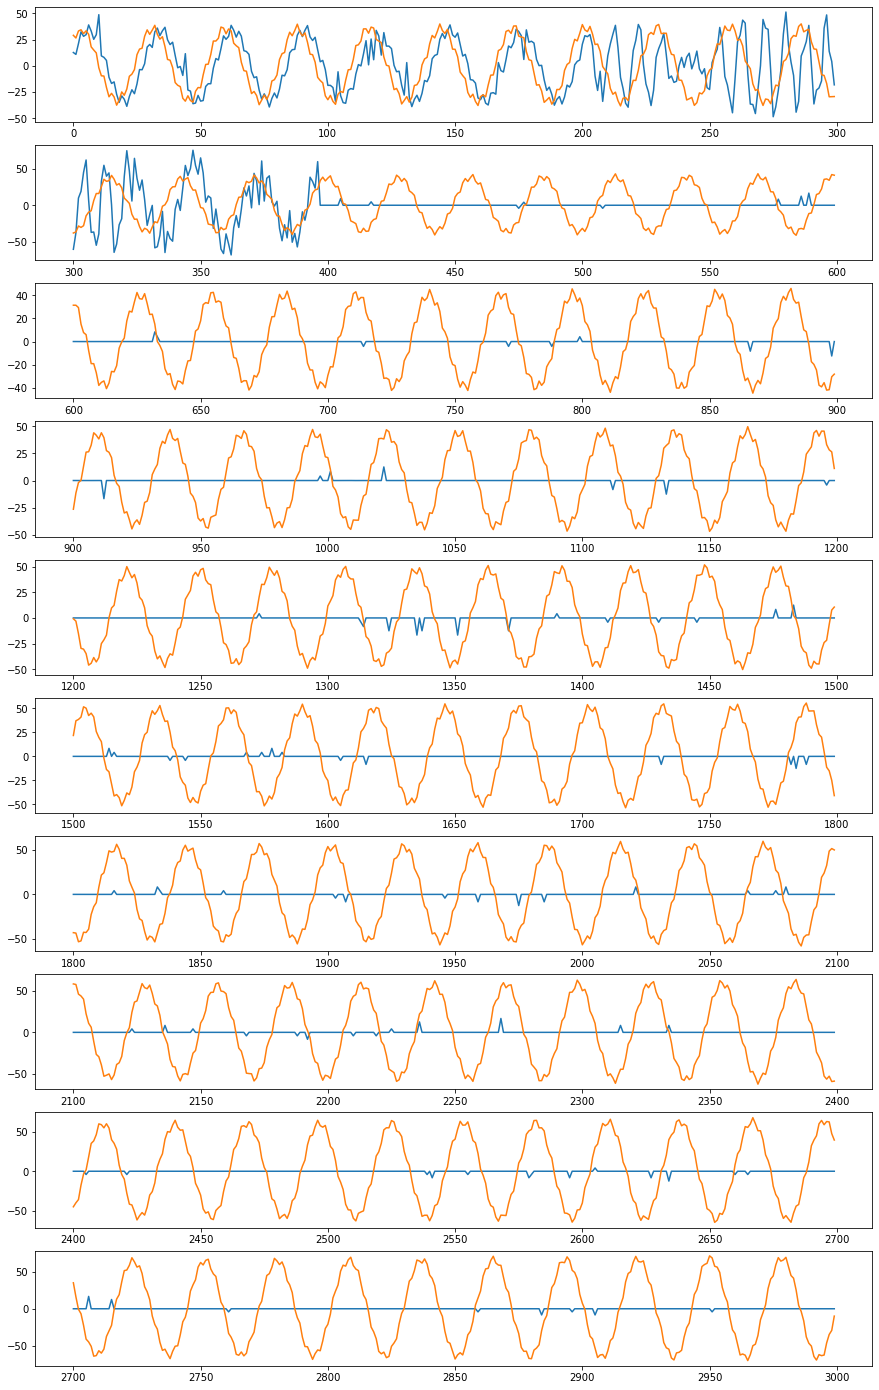

In [24]:
fig, ax = plt.subplots(10,1, figsize=(15,25))

n = 300
index = 0

for i in range(0, len(data_0),n):
    ax[index].plot(range(i,i+n), data_0[i:i+n]['0'])
    ax[index].plot(range(i,i+n), pred_df_0[i:i+n]['0_pred'])
    index+=1

#### By observing the graph for just one signal, we can see that the actual graph is very different from the predicted graph after a certain point of time. The point where the fault starts and the failure starts are points which show the maximum difference. I will calculate the difference between the peaks of the two graphs.

## Fault point estimation

In [25]:
#calculating the first different peak
def fault_point(df, pred_df, col_name_df, col_name_pred_df, order=25):

    max_actual = argrelextrema(df[col_name_df].values, np.greater, order=order)[0]
    max_pred = argrelextrema(pred_df[col_name_pred_df].values, np.greater, order=order)[0]

    list_diff = []
    list_diff_pred = []
    index_list = []

    for i in range(1, len(max_actual)):
        #print(i)
        list_diff.append(max_actual[i] - max_actual[i-1])
        list_diff_pred.append(max_pred[i] - max_pred[i-1])
        index_list.append(i*25)

    df = pd.DataFrame(zip(list_diff, list_diff_pred), index=index_list, columns=['peak', 'peak_pred'])
    
    different_peak = np.array(np.where((df['peak'] - df['peak_pred']) > 1.5 * df['peak_pred']))
    first_different_peak = different_peak.min() * 25
    
    return first_different_peak

### Fault date and time for each signal of machine 0

In [26]:
first_different_peak_0 = fault_point(data_0, pred_df_0, '0', '0_pred')
first_different_peak_1 = fault_point(data_0, pred_df_0, '1', '1_pred')
first_different_peak_2 = fault_point(data_0, pred_df_0, '2', '2_pred')
first_different_peak_3 = fault_point(data_0, pred_df_0, '3', '3_pred')
fault_day_number = round(np.mean([first_different_peak_0, first_different_peak_1, first_different_peak_2, first_different_peak_3]))

In [27]:
data_0.index[fault_day_number]

Timestamp('2019-03-23 08:39:03.181060354')

### Thus, the signals for machine 0 starts behavily differently on 2019-03-23. Since, it is necessary to pinpoint about the upcoming fault and failure on time, so I can take 2 days time period as the fault window in which I will inform the concerned department about the upcoming failure. Any bigger window might lead to machine failure and loss to the company.

### As per the model predictions and calculations performed, faulty behavior of machine 0 will be notified in between [2019-03-23, 2019-03-25].

## Failure point estimation

#### In order to find the failure point, I am taking the mean of the absolute values and checking the first occurence of 0. 

In [28]:
#calculating failure point
def failure_point(df):
    
    df['mean'] = df.apply(lambda row: ((abs(row['0'])) + (abs(row['1'])) + (abs(row['2']))+ (abs(row['3'])))/4, axis=1)
    failure_point = np.array(np.where(round(df['mean']) == 0))
    failure_point_start = failure_point.min()
    
    return failure_point_start

failure_day_number = failure_point(data_0)

In [29]:
data_0.index[failure_day_number]

Timestamp('2019-05-13 09:03:32.470823608')

### Thus, the signals for machine 0 starts becoming zero on 2019-05-13. Thus, the failure date for machine 0 is 2019-05-13.

## Single Function to detect Fault and Failure Points for a machine

In [30]:
FILE_DIRECTORY = 'exampleco_data/'
NUM_COLS = 4
ROLLING_WINDOW = 60
MIN_PERIODS = 1

def detect_fault_and_failure_points(filename):
    
    #reading the file
    filepath = FILE_DIRECTORY + filename
    data = pd.read_csv(filepath)
    
    #pre-processing
    data.rename(columns={"Unnamed: 0":"DateTime"},inplace=True)
    data.DateTime = pd.to_datetime(data.DateTime)
    data.set_index('DateTime', inplace=True)
    
    #replacing outliers
    for i in range(NUM_COLS):
        replace_outliers(data, str(i), rolling_window=ROLLING_WINDOW, min_periods=MIN_PERIODS)
        
    #predcitions by VAR model
    pred_df = prediction_df(data)
    
    fault_points = []
    
    for i in range(NUM_COLS):
        fault_points.append(fault_point(data, pred_df, str(i), str(i)+'_pred'))
        
    fault_day_number = round(np.mean(fault_points))
    fault_date = data.index[fault_day_number]
    
    failure_day_number = failure_point(data)
    failure_date = data.index[failure_day_number]
    
    return fault_date, failure_date

In [31]:
for i in range(0, 8):
    try:
        print("Filename:", 'machine_' + str(i) + '.csv', "\n", detect_fault_and_failure_points('machine_' + str(i) + '.csv'), "\n")
    except:
        print("Filename:", 'machine_' + str(i) + '.csv', "\n", "Problem in detecting file or fault and failure points. As per my knowledge, this is due to failures in finding the peaks as argrelextrema doesn't consider repeated values to detect peaks. \n")

Filename: machine_0.csv 
 (Timestamp('2019-03-23 08:39:03.181060354'), Timestamp('2019-05-13 09:03:32.470823608')) 

Filename: machine_1.csv 
 Problem in detecting file or fault and failure points. As per my knowledge, this is due to failures in finding the peaks as argrelextrema doesn't consider repeated values to detect peaks. 

Filename: machine_2.csv 
 (Timestamp('2020-01-15 11:02:08.442814272'), Timestamp('2020-09-18 21:00:54.018006008')) 

Filename: machine_3.csv 
 Problem in detecting file or fault and failure points. As per my knowledge, this is due to failures in finding the peaks as argrelextrema doesn't consider repeated values to detect peaks. 

Filename: machine_4.csv 
 Problem in detecting file or fault and failure points. As per my knowledge, this is due to failures in finding the peaks as argrelextrema doesn't consider repeated values to detect peaks. 

Filename: machine_5.csv 
 (Timestamp('2019-03-15 00:35:03.101033678'), Timestamp('2019-05-13 09:03:32.470823608')) 

F

### Thank you so much for going through my code. Please see the attached report for more details about the approach used, limitations and all the reasoning.